## Sources and details of the dataset

Foursquare is a social media platform where users can share their locations and rate venues. This dataset contains 09/2013's values.

You need to download the dataset with torrent to access it.

> https://archive.org/download/201309_foursquare_dataset_umn/201309_foursquare_dataset_umn_archive.torrent

<img src="images/raw_dataset.png">

### [Content of Files](https://archive.org/details/201309_foursquare_dataset_umn)

 * users.dat: Consists of a set of users such that each user has a unique id and a geospatial location (latitude and longitude) that represents the user home town location.
 * venues.dat: Consists of a set of venues (e.g., restaurants) such that each venue has a unique id and a geospatial location (lattude and longitude).
 * checkins.dat: Marks the checkins (visits) of users at venues. Each check-in has a unique id as well as the user id and the venue id.
 * socialgraph.dat: Contains the social graph edges (connections) that exist between users. Each social connection consists of two users (friends) represented by two unique ids (first_user_id and second_user_id).
 * ratings.dat: Consists of implicit ratings that quantifies how much a user likes a specific venue.

## A proposition on what, why and how to work with the data

We don't have a clear hypothesis beforehand we will conduct exploratory analysis.

### How we will work with foursquare dataset?

  * Download dataset from source with torrent
  * Clean and transform it with python
  * Import it to PostgreSQL and design schema, tables and indexing for performance improvements.
  * Analyze it with sql queries
  * Visualize the results with python(i.e. matplotlib)
  * Share the report and results with ipython notebook

## Outline of the report

* Introduction and details of the dataset.
* Basic descriptive analysis of each table.
* Social network analysis.
* Reviewers and review activity analysis.
* Venue popularity and rating analysis.

## Accessing data from file system and cleaning it

In [1]:
import time
import math
import os
import re
import filecmp

source_dir = os.getcwd()
raw_data_folder = source_dir+"\\data\\raw"
clean_data_folder = source_dir+"\\data\\clean"

for filename in filecmp.dircmp(raw_data_folder, clean_data_folder).common:
    print("{filename} already exists.".format(filename=filename))

for filename in filecmp.dircmp(raw_data_folder, clean_data_folder).left_only: #this prevents processing already cleaned data, swap with below comment if you want to process it anyway
#for filename in os.listdir(raw_data_folder):
    with open(os.path.join(raw_data_folder, filename), 'r') as f: #open in readonly mode
        start_time = math.trunc(time.time())
        clean_file = open(os.path.join(clean_data_folder,filename),"w")
        line_number = 0
        for line in f:
            line_number += 1 #Don't carry this to end of the elif statements otherwise line number will be zero indefinitely
            if(line_number in range(1,3)):
                #print("Deleted line: {line_number}".format(line_number=line_number))
                continue
            elif(line.endswith("rows)\n")):
                break
            else:
                clean_format = line.replace(" ","").replace("|",";")
                clean_file.write(clean_format)
        clean_file.close()
        end_time = math.trunc(time.time())
        print("Cleaned and created {filename} in {execute_time} seconds".format(execute_time=end_time-start_time, filename=filename))

checkins.dat already exists.
ratings.dat already exists.
socialgraph.dat already exists.
users.dat already exists.
venues.dat already exists.


In [2]:
import psycopg2

pghost = "localhost"
pguser = "postgres"
pgdatabase = "MEF-BDA-PROD"
pgport = "5432"
pgpassword = "123"
#Normally you shouldn't keep database connections in your source code but this one is ok because we are only going to work in local.

conn_string = 'host={pghost} port={pgport} dbname={pgdatabase} user={pguser} password={pgpassword}'.format(pgdatabase=pgdatabase,pguser=pguser,pgpassword=pgpassword,pghost=pghost,pgport=pgport)
conn=psycopg2.connect(conn_string)
cur=conn.cursor()

def check_if_table_exists(schema,table):
    cur.execute("select exists(select * from information_schema.tables where table_schema='{schema}' AND table_name='{table}')".format(schema=schema, table=table))
    return cur.fetchone()[0]

def check_if_index_exists(index):
    cur.execute("SELECT EXISTS(SELECT * FROM PG_CLASS WHERE relname = '{index}')".format(index=index))
    return cur.fetchone()[0]

if(check_if_table_exists('ODS','EXT_FS_USERS')):
    print('Table ODS.EXT_FS_USERS already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FS_USERS"
    (
    id integer,
    latitude double precision,
    longitude double precision
    )

    TABLESPACE pg_default;

    ALTER TABLE "ODS"."EXT_FS_USERS"
    OWNER to postgres;
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Table ODS.EXT_FS_USERS created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FS_VENUES')):
    print('Table ODS.EXT_FS_VENUES already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FS_VENUES"
    (
    id integer,
    latitude double precision,
    longitude double precision
    )
    
    TABLESPACE pg_default;

    ALTER TABLE "ODS"."EXT_FS_VENUES"
    OWNER to postgres;
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FS_VENUES created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FS_SOCIALGRAPH')):
    print('Table ODS.EXT_FS_SOCIALGRAPH already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FS_SOCIALGRAPH"
    (
    first_user_id integer,
    second_user_id integer
    )

    TABLESPACE pg_default;

    ALTER TABLE "ODS"."EXT_FS_SOCIALGRAPH"
    OWNER to postgres;
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Table ODS.EXT_FS_SOCIALGRAPH created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FS_RATINGS')):
    print('Table ODS.EXT_FS_RATINGS already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FS_RATINGS"
    (
    user_id integer,
    venue_id integer,
    rating integer
    )

    TABLESPACE pg_default;

    ALTER TABLE "ODS"."EXT_FS_RATINGS"
    OWNER to postgres;
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Table ODS.EXT_FS_RATINGS created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FS_CHECKINS')):
    print('Table ODS.EXT_FS_CHECKINS already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FS_CHECKINS"
    (
    id integer,
    user_id integer,
    venue_id integer,
    latitude double precision,
    longitude double precision,
    created_at text COLLATE pg_catalog."default"
    )

    TABLESPACE pg_default;

    ALTER TABLE "ODS"."EXT_FS_CHECKINS"
    OWNER to postgres;
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Table ODS.EXT_FS_CHECKINS created in {execute_time} seconds.".format(execute_time=end_time-start_time))

Table ODS.EXT_FS_USERS already exists.
Table ODS.EXT_FS_VENUES already exists.
Table ODS.EXT_FS_SOCIALGRAPH already exists.
Table ODS.EXT_FS_RATINGS already exists.
Table ODS.EXT_FS_CHECKINS already exists.


Lets import the data with;

```postgresql
\COPY "ODS"."EXT_FS_USERS" FROM '[FilePath]/users.dat' WITH (FORMAT CSV, DELIMITER ';');
\COPY "ODS"."EXT_FS_VENUES" FROM '[FilePath]/venues.dat' WITH (FORMAT CSV, DELIMITER ';', FORCE_NULL(latitude,longitude));
\COPY "ODS"."EXT_FS_SOCIALGRAPH" FROM '[FilePath]/socialgraph.dat' WITH (FORMAT CSV, DELIMITER ';');
\COPY "ODS"."EXT_FS_RATINGS" FROM '[FilePath]/ratings.dat' WITH (FORMAT CSV, DELIMITER ';');
\COPY "ODS"."EXT_FS_CHECKINS" FROM '[FilePath]/checkins.dat' WITH (FORMAT CSV, DELIMITER ';');
``` 

**You should use PSQL(SQL Shell) instead of IDE because \COPY command only works there, also \COPY command should not be mistaken with COPY command.**

We imported foursquare data to postgresql tables but there is a one thing we should do before proceeding to work with it.

There was an issue while importing date time values so we imported them as text values, we can create a new table with;

```postgresql
CREATE TABLE TABLE_NAME AS
SELECT * 
FROM OLD_TABLE_NAME; 
```

In [3]:
if(check_if_table_exists('EDW','EXT_FS_CHECKINS')):
    print('Table EDW.EXT_FS_CHECKINS already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."EXT_FS_CHECKINS" AS
    SELECT
    id,
    user_id,
    venue_id,
    latitude,
    longitude,
    to_timestamp(created_at, 'YYYY-MM-DDhh24:mi:ss') AS created_at
    FROM "ODS"."EXT_FS_CHECKINS";
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Table EDW.EXT_FS_CHECKINS created in {execute_time} seconds.".format(execute_time=end_time-start_time))

Table EDW.EXT_FS_CHECKINS already exists.


# Data Analysis and Visualization

## Most 200 ranked venues

In this example we are going to look at most 200 ranked venues which have at least 20 ratings by users and visualize it in basemap library.

In [4]:
if(check_if_table_exists('EDW','DWH_VENUE_RATINGS')):
    print('Table EDW.DWH_VENUE_RATINGS already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_VENUE_RATINGS" AS
    SELECT
    venue_id,
    AVG(rating) AS average_rating,
    COUNT(*) AS total_ratings,
    VNS.latitude,
    VNS.longitude
    FROM "ODS"."EXT_FS_RATINGS" RTG
    INNER JOIN "ODS"."EXT_FS_VENUES" VNS ON (RTG.venue_id = VNS.id)
    WHERE 1=1
    AND VNS.latitude IS NOT NULL
    AND VNS.longitude IS NOT NULL
    GROUP BY RTG.venue_id,
    VNS.latitude,
    VNS.longitude
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Table EDW.DWH_VENUE_RATINGS created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_index_exists('IDX_DWH_VENUE_RATINGS#01')):
    print('Index IDX_DWH_VENUE_RATINGS#01 already exists')
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE INDEX "IDX_DWH_VENUE_RATINGS#01"
    ON "EDW"."DWH_VENUE_RATINGS" USING btree
    (total_ratings ASC NULLS LAST)
    ;
    """)
    end_time = math.trunc(time.time())
    cur.execute('COMMIT;')
    print("Index IDX_DWH_VENUE_RATINGS#01 created in {execute_time} seconds".format(execute_time=end_time-start_time))

Table EDW.DWH_VENUE_RATINGS already exists.
Index IDX_DWH_VENUE_RATINGS#01 already exists


In [5]:
import pandas as pd

sql_command = """
WITH RD AS(
SELECT VR.*,
RANK() OVER(ORDER BY average_rating DESC, total_ratings DESC, venue_id) AS ORDER
FROM "EDW"."DWH_VENUE_RATINGS" VR
WHERE 1=1
AND VR.total_ratings >= 50
)
SELECT * 
FROM RD
ORDER BY RD.order
LIMIT 200;
"""
df_venue_ratings = pd.read_sql(sql_command,conn)
df_venue_ratings.head(20)

,venue_id,average_rating,total_ratings,latitude,longitude,order
0,407336,4.006897,145,42.494700,-71.188600,1
1,957067,4.000000,68,42.494700,-71.188600,2
2,5732,3.986301,73,36.145361,-115.179806,3
3,111995,3.933333,105,42.745885,-71.109502,4
4,9883,3.886700,203,32.707000,-117.161851,5
5,417,3.881773,203,40.735164,-74.004691,6
6,13116,3.818182,77,40.725135,-74.002087,7
7,33197,3.800000,60,37.796661,-122.422051,8
8,15193,3.698276,116,40.743095,-73.988457,9
9,19778,3.692308,52,40.752117,-74.008691,10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


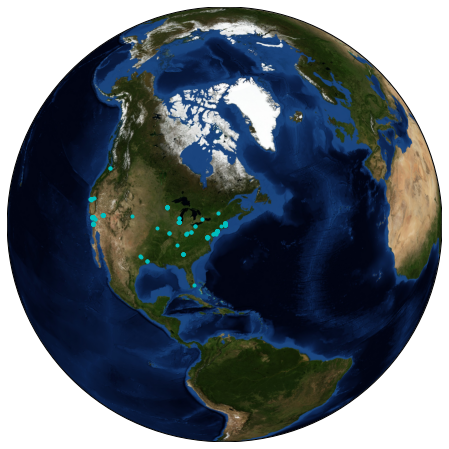

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))

m = Basemap(projection='ortho', resolution=None, lat_0=df_venue_ratings['latitude'][0], lon_0=df_venue_ratings['longitude'][0],)

for c in df_venue_ratings['order']:
    i = c-1
    x, y = m(df_venue_ratings['longitude'][i], df_venue_ratings['latitude'][i])
    plt.plot(x, y, 'co', markersize= df_venue_ratings['average_rating'][i])

m.bluemarble()

In [7]:
#cur.close()
#conn.close()

## Sources:

 1. [Dataset](https://archive.org/details/201309_foursquare_dataset_umn)

 2. [How to open every file in a folder?](https://stackoverflow.com/questions/18262293/how-to-open-every-file-in-a-folder)

 3. [Python- reading a file line by line and processing](https://stackoverflow.com/questions/53749062/python-reading-a-file-line-by-line-and-processing)

 4. [File and Directory Comparisons with Python](https://janakiev.com/blog/python-filecmp/)

 5. [Checking if a table exist with psycopg2 on postgreSQL](https://stackoverflow.com/questions/1874113/checking-if-a-postgresql-table-exists-under-python-and-probably-psycopg2)

 6. [Checking if index exist](https://stackoverflow.com/questions/45983169/checking-for-existence-of-index-in-postgresql)

 7. [Download basemap](https://www.lfd.uci.edu/~gohlke/pythonlibs/)